Introduction

For my Capstone project I am trying to look at credit card fraud. The question I am wanting to explore in this project is if machine learning algorithms can learn and predict fraud accuratly with low risk for False Positives and False Negatives. More specifically, can fraud be detected accuratly without mistaking non-fraud cases as fraud. Frequent False Positive results would cause customer satisfaction and retention to be negativly affected while False Negatives would be bad for company profits, reputation, and customer satisfaction.

Sub-Population

European credit card transactions from 2013.

Data Source

The data source I will use will be from kaggle.com titled ‘Credit Card Fraud Detection’. The link to the data is below: https://www.kaggle.com/mlg-ulb/creditcardfraud. This dataset contains a list of transactions over two days, where 492 frauds were found out of 284,807 transactions. Although the dataset is unbalanced it presents a unique challenge I have not dealt with yet. The dataset also contains numerical input variables which are the result of PCA transformation. The transformation was done due to confidentiallity issues with personal information so I will not have access to the original data. Only features that have not been transformed are are 'Time' and 'Amount'. The feature "Class" is the response variable to fraud with values of [0] for normal and [1] for fraud.

Methodology

I will first need to address undersampling by identifying the train set with either undersampling, oversampling, or SMOTE techniques. Then I will train the data as a whole with logistic regression, random forest, decision tree, and support vector machine classifiers. I will tune each model and test each with cross validation, accuracy, and recall scores so that I can ensure the models are not overfitting and creating lots of False Positive and False negative results. Based on results of the best two models I will then apply them to the original dataset and test it for accuracy and recall. I will also try to perform ROC and AUC analysis to evaluate data and test thresholds for tuning.

If results are poor I will decide either to do feature engineering or perform a different sampling technique from the three mentioned previsouly (Undersampling, Oversampling, and SMOTE) to see if results will be different.

Purpose

The results of my analysis will be useful to stakeholders for different credit card companies as well as different credit card reporting companies. It will give them insight into what machine learning models are successful in identifying fraud as well as their limitations.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
#bring in libraries for potential tests to run
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from mpl_toolkits.mplot3d import Axes3D
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve, auc,roc_auc_score,roc_curve, classification_report
from scipy.stats import jarque_bera
from scipy.stats import normaltest
from scipy.stats import boxcox
from sklearn.neighbors import KNeighborsClassifier
!pip install sklearn
from sklearn import preprocessing, neighbors, ensemble

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# **Download Data**

In [4]:
data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Checking the size of our data (rows, columns)
print(data.shape)

(284807, 31)


Since there are only 31 columns we can do df.info() to find out more information about df.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Every column appears to have the same amount of data so there are probably are no null or scoreless values. Lets check to confirm.

In [7]:
# find percent missing values
data.isna().mean()

Time      0.0
V1        0.0
V2        0.0
V3        0.0
V4        0.0
V5        0.0
V6        0.0
V7        0.0
V8        0.0
V9        0.0
V10       0.0
V11       0.0
V12       0.0
V13       0.0
V14       0.0
V15       0.0
V16       0.0
V17       0.0
V18       0.0
V19       0.0
V20       0.0
V21       0.0
V22       0.0
V23       0.0
V24       0.0
V25       0.0
V26       0.0
V27       0.0
V28       0.0
Amount    0.0
Class     0.0
dtype: float64

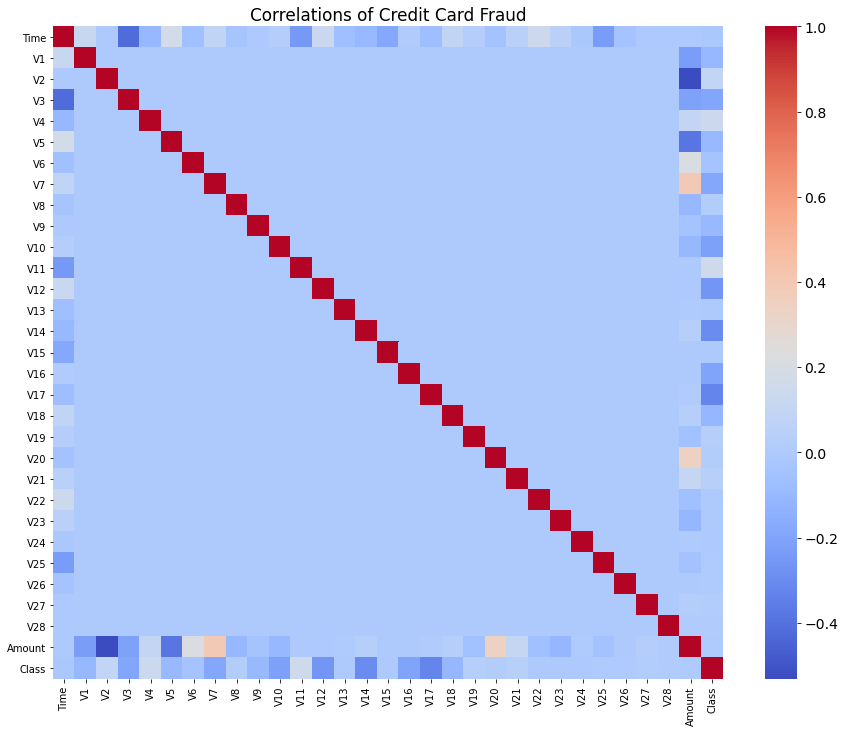

In [8]:
import seaborn as sns
# Calculate correlations
corr = data.corr()
# Heatmap
fig, ax = plt.subplots(figsize=(15,12))
plt.rcParams['font.size'] = 14
ax.set_title('Correlations of Credit Card Fraud')
 
sns.heatmap(corr, ax = ax, cmap = 'coolwarm')

Class 0: 284315
Class 1: 492
Proportion: 577.88 : 1


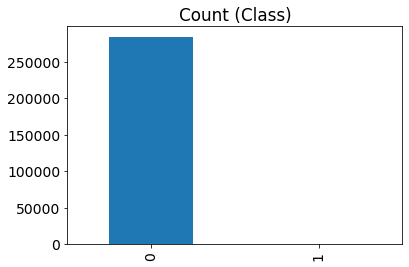

In [9]:
target_count = data.Class.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (Class)');

In [10]:
data['Class'].value_counts(normalize=True) * 100

0    99.827251
1     0.172749
Name: Class, dtype: float64

First glance this dataset does not have significant collinearity issues but it does have a large data imbalance with 99.82% of the dataset not resulting in credit card fraud. Running any models in the current state would result in overfitting. Therefore we need to think of ways to deal with the data imbalance.

* Collect more data? Nice strategy but not applicable in this case
* Changing the performance metric:
    * Use the confusion matrix to calculate Precision, Recall
    * F1score (weighted average of precision recall)
    * ROC curves - calculates sensitivity/specificity ratio.
* Resampling the dataset
    * One way to achieve this is by OVER-sampling or UNDER-sampling.  OVER-sampling is adding copies of the under-represented class(Class [1]) (Ideally when you have little data).
    * UNDER-sampling is where you delete instances from the over-represented class(class [0]) (better when he have lot's of data).

# **Approach**

1. Feature engineering is not necessary to start with as the dataset has been downgraded to contain 30 features and PCA transformation has been performed for all columns accept "Time" and "Amount".

2. Because of data imbalance it would be worth testing and comparing models before and after resampling to see the difference. Simple logistic regression, decision tree, random forest, gradiant boosting, and support vector machine classifiers will be used. 

3. Evaluate above models in previous step with performance metrics. Best two on the training set (determined by cross validation, accuracy, and recall) will be applied to test set (entire dataset).

4. Repeat best resampling/not resampling method, by tuning the parameters in the logistic regression classifier

5. Repeat steps 1-3 after removing some less impactful features to see if results are different

# **Setting our input and target variables + resampling.**

**Testing and training models on entire dataset to emphasize overfitting problem**

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Remove 'id' and 'target' columns
labels = data.drop(['Class'], axis=1)

X = labels
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.96%


In [12]:
model = XGBClassifier()
model.fit(X_train[['V28']], y_train)
y_pred = model.predict(X_test[['V28']])

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.85%


Confusion matrix:
 [[56872     3]
 [   19    68]]


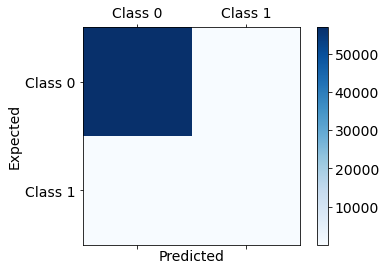

Recall metric in the testing dataset:  0.7816091954022989


In [13]:
from sklearn.metrics import confusion_matrix

X = labels
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()
print ("Recall metric in the testing dataset: ", recall_score(y_test, y_pred))

Because the accuracy is almost identical with one metric (V28) as it is with all metrics we know the high accuracy rate is an illusion. The recall score verifys this.

# **Random under-Sampling**

Due to the overfitting issues with the imbalanced dataset it needs to be reframed for the training set to accuratly model and compare to the entire dataset. Because we have greater then 280,000 samples to work with undersampling appears to be better than oversampling. SMOTE can then be applied for comparison if models perform poorly.

In [14]:
# Class count
count_class_0, count_class_1 = data.Class.value_counts()

# Divide by class
df_class_0 = data[data['Class'] == 0]
df_class_1 = data[data['Class'] == 1]

Random under-sampling:
1    492
0    492
Name: Class, dtype: int64


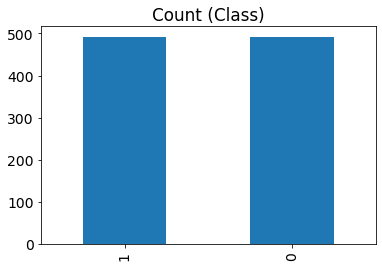

In [15]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Class.value_counts())

df_test_under.Class.value_counts().plot(kind='bar', title='Count (Class)');

After splitting the dataset randomly with undersampling we need to also split the entire dataset for testing the model

In [16]:
#organize original dataset for testing models at the end
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Class']),data['Class'],test_size = 0.2, random_state = 42, stratify = data['Class'])

1    492
0    492
Name: Class, dtype: int64


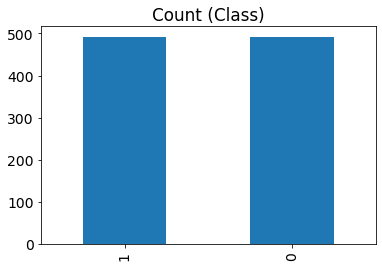

In [17]:
#organizing and sorting undersampled dataset for training

# number of fraud cases
fraud = len(data[data['Class'] == 1])

#get indices of non fraud samples
non_fraud_indices = data[data.Class == 0].index

#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices,fraud, replace=False)

#find fraud samples
fraud_indices = data[data.Class == 1].index

#concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices,random_indices])

#balance the DF
under_sample = data.loc[under_sample_indices]


# histograms of new data
print(under_sample.Class.value_counts())
under_sample.Class.value_counts().plot(kind='bar', title='Count (Class)');

# **Using Models on Undersampled Data**

I propose trying 4 different models (logistic regression, random forest, decision tree, and support vector machine) for training and then using the top two for the test set. 
1. Logistic regression will be used because it can be regularized to avoid overfitting, however if data is not linear it may perform poorly. 
2. Decision tree classifiers will be used because they perform well with outliers, non-linear relationships, and issues with overfitting will be analyzed and adjusted with tests.
3. Random forest will be used for similar reasons to decisions trees for comparison between the two.
4. Support Vector Machine classifier will be used for comparison. It does have issues with larger datasets but it is more robust against overfitting.

# Model 1: Logistic Regression

In [18]:
#setup train and test sets
X_under = under_sample.loc[:,under_sample.columns != 'Class']
y_under = under_sample.loc[:,under_sample.columns == 'Class']
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(X_under,y_under,test_size = 0.2, random_state = 2)

Tune the parameters firs for best fit.

In [19]:
# example of grid searching key hyperparametres for logistic regression
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
# define dataset
X = X_under_train
y = y_under_train
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2', 'l1']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937715 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.927578 (0.025884) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.933918 (0.024628) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.933057 (0.023030) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.504890 (0.012253) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.498107 (0.007182) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.930109 (0.025620) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.498107 (0.007182) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.929693 (0.025182) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937715 (0.021904) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.933057 (0.023030) with: {'C': 10, 'penalty'

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [20]:
lr_under = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr_under.fit(X_under_train,y_under_train)
y_under_pred = lr_under.predict(X_under_test)

print(recall_score(y_under_test,y_under_pred))
print(accuracy_score(y_under_test,y_under_pred))

# Score the model on it's accuracy using cross validation
lr_score = cross_val_score(lr_under, X_under_test, y_under_test, cv=7)
print(f'Logistic Regression Score: {lr_score.mean(): .3f} +/- {2*lr_score.std(): .4f}')

0.8947368421052632
0.934010152284264
Logistic Regression Score:  0.939 +/-  0.0497


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

Recall metric in the testing dataset:  0.8947368421052632


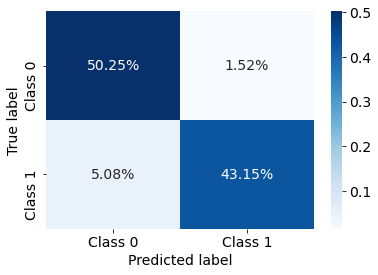

In [21]:
import seaborn as sns
# Predicting the classes from the test set
y_pred_lr = lr_under.predict(X_under_test)

# Creating a confusion matrix
cm_dt = confusion_matrix(y_under_test, y_pred_lr)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, cmap='Blues', 
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_under_test, y_pred_lr))

My model did a pretty good job of predicting fraud with the undersampled data but lets try with other models

# Model 2: Decission Tree Classifier

Tune hyperparameters for best fit

In [22]:
# How to optimize hyper-parameters of a DecisionTree model using Grid Search in Python ?
def Snippet_146_Ex_2():
    print('**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**\n')


    # importing libraries
    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler

    # Loading wine dataset
    data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
    X = X_under_train
    y = y_under_train

    # Creating an standardscaler object
    std_slc = StandardScaler()

    # Creating a pca object
    pca = decomposition.PCA()

    # Creating a DecisionTreeClassifier
    dec_tree = tree.DecisionTreeClassifier()

    # Creating a pipeline of three steps. First, standardizing the data.
    # Second, tranforming the data with PCA.
    # Third, training a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('dec_tree', dec_tree)])

    # Creating Parameter Space
    # Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1]+1,1))

    # Creating lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [2,4,6,8,10,12]

    # Creating a dictionary of all the parameter options 
    # Note that we can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

    # Conducting Parameter Optmization With Pipeline
    # Creating a grid search object
    clf_GS = GridSearchCV(pipe, parameters)

    # Fitting the grid search
    clf_GS.fit(X, y)

    # Viewing The Best Parameters
    print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
    print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
    print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

   
Snippet_146_Ex_2()

**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**

Best Criterion: gini
Best max_depth: 6
Best Number Of Components: 14

DecisionTreeClassifier(max_depth=6)


In [23]:
# Import model
from sklearn.tree import DecisionTreeClassifier

# Instantiate (start up) model
dt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 6, random_state=42)
# Fit model on the training data
dt.fit(X_under_train, y_under_train)

# Score the model on it's accuracy using cross validation
dt_score = cross_val_score(dt, X_under_test, y_under_test, cv=29)
print(f'Decision Tree Score: {dt_score.mean(): .3f} +/- {2*dt_score.std(): .4f}')

Decision Tree Score:  0.897 +/-  0.2511


Recall metric in the testing dataset:  0.9157894736842105


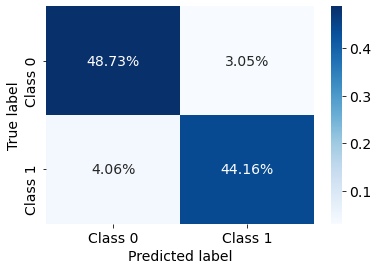

In [24]:

# Predicting the classes from the test set
y_pred_dt = dt.predict(X_under_test)

# Creating a confusion matrix
cm_dt = confusion_matrix(y_under_test, y_pred_dt)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, cmap='Blues', 
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_under_test, y_pred_dt))

This model is not as good as logistic regression but still has a pretty good cross val score and recall.

# Model 3: Random Forest Classifier

Tune hyperparameters for best fit

In [25]:
# Import model
from sklearn.ensemble import RandomForestClassifier
# define dataset
X = X_under_train
y = y_under_train
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2', 'auto']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best: 0.930932 using {'max_features': 'auto', 'n_estimators': 1000}
0.922915 (0.026467) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.925024 (0.026532) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.930082 (0.025437) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.924175 (0.031254) with: {'max_features': 'log2', 'n_estimators': 10}
0.925024 (0.025704) with: {'max_features': 'log2', 'n_estimators': 100}
0.928822 (0.026204) with: {'max_features': 'log2', 'n_estimators': 1000}
0.927978 (0.025793) with: {'max_features': 'auto', 'n_estimators': 10}
0.930109 (0.026399) with: {'max_features': 'auto', 'n_estimators': 100}
0.930932 (0.026051) with: {'max_features': 'auto', 'n_estimators': 1000}


In [26]:
# Instantiate (start up) model
rf = RandomForestClassifier(max_features = 'log2', n_estimators = 100, random_state=42)
# Fit model on the training data
rf.fit(X_under_train, y_under_train)

# Score the model on it's accuracy using cross validation
rf_score = cross_val_score(rf, X_under_test, y_under_test, cv=3)
print(f'Random Forest Score: {rf_score.mean(): .5f} +/- {2*rf_score.std(): .6f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Random Forest Score:  0.93901 +/-  0.025700


Recall metric in the testing dataset:  0.9263157894736842


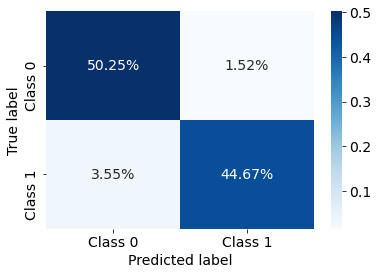

In [27]:
# Predicting the classes from the test set
y_under_pred_rf = rf.predict(X_under_test)

# Creating a confusion matrix
cm_rf = confusion_matrix(y_under_test, y_under_pred_rf)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_under_test, y_under_pred_rf))

Tune parameters to get best fit

# Model 4: Support Vector Machine Classifier

Tune parameters first to find best fit

In [28]:
# define dataset
X = X_under_train
y = y_under_train
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.557811 using {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543433 (0.052047) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.545153 (0.056640) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.485811 (0.059202) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543427 (0.051977) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.539608 (0.057324) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.485384 (0.060687) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543433 (0.052654) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.524370 (0.061591) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.486644 (0.058130) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.544704 (0.053181) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.521411 (0.060547) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.557811 (0.039727) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.546825 (0.048819) with: {'C': 0.01, 'gamma': 'sca

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [29]:
# Import model
from sklearn.svm import SVC

# Instantiate (start up) model
svc = SVC(C = .1, gamma ='scale', kernel = 'sigmoid', random_state = 42)
# Fit model on the training data
svc.fit(X_under_train, y_under_train)

# Score the model on it's accuracy using cross validation
svc_score = cross_val_score(svc, X_test, y_test, cv=3)
print(f'Support Vector Machine Classifier Score: {svc_score.mean(): .3f} +/- {2*svc_score.std(): .4f}')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Support Vector Machine Classifier Score:  0.998 +/-  0.0000


Recall metric in the testing dataset:  0.1368421052631579


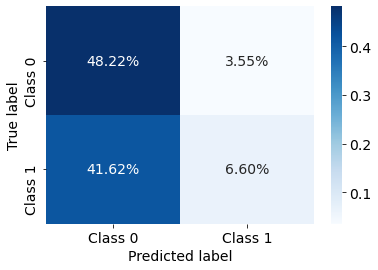

In [30]:
# Predicting the classes from the test set
y_pred_svc = svc.predict(X_under_test)

# Creating a confusion matrix
cm_svc = confusion_matrix(y_under_test, y_pred_svc)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_svc/np.sum(cm_svc), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_under_test, y_pred_svc))

# **Summary of Model Results**

    1. Logistic Regression             cvs = 93.4 recall = 93.7
    2. Decision Trees                  cvs = 89.7 recall = 93.7
    3. Random Forest                   cvs = 94.4 recall = 91.6
    4. Support Vector Classifier       cvs = 99.8 recall = 13.7

Based on the results with the models random forest and logistic regression performed best.Decision tree was not too far behind but support vector classifier had a significantly lower recall. Therefore, only the best two will be performed on the whole dataset as the computational time could be significant if I did all four. 

# Logistic Regression Classifier - Whole Dataset

Due to the imbalacing of the data, many observations could be predicted as False Negatives or False Positives. Therefore recall score is what we are most interested in because it will help us try to capture the most fraudulent transactions. Technically, we could even apply weights since False Positives are not as drastic as False Negatives

plot confusion matrix

In [31]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

**Predictions on test set and plotting confusion matrix**

We have been talking about using the recall metric as our proxy of how effective our predictive model is. Even though recall is still the recall we want to calculate, just bear in mind that the undersampled data hasn't have a skewness towards a certain class, which doesn't make recall metric as critical.

Recall metric in the testing dataset:  0.8947368421052632


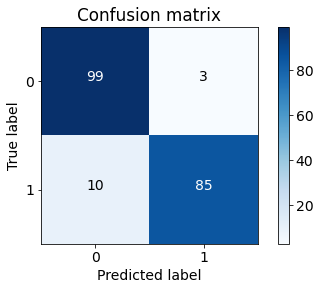

In [32]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X_under_train, y_under_train.values.ravel(),)
y_pred_undersample = lr.predict(X_under_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_under_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

This model has a recall of about 93.6% for the test set. However, this is with the undersampled data not the whole df.

**Apply model to entire DF**

**Logistic Regression**

Logistic Regression Score:  0.999 +/-  0.0007
Recall metric in the testing dataset:  0.8979591836734694


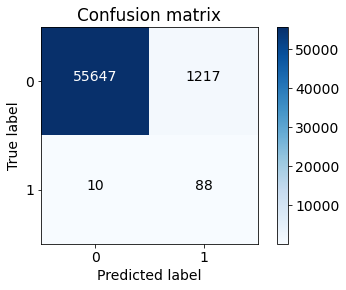

In [33]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X_under_train,y_under_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

# Score the model on it's accuracy using cross validation
lr_score = cross_val_score(lr, X_test, y_test, cv=7)
print(f'Logistic Regression Score: {lr_score.mean(): .3f} +/- {2*lr_score.std(): .4f}')
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

Still the recall is 91.8% even when applied to a larger dataset. However, there are more False Positives than False Negatives. Although, I would prefer this over more False Negatives more False Positives does risk negativly impacting customer satisfaction. Therefore, more testing should be done to reduce False Positives.

**Random Forest**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest score:  0.99940 +/-  0.000216
Recall metric in the testing dataset:  0.9795918367346939


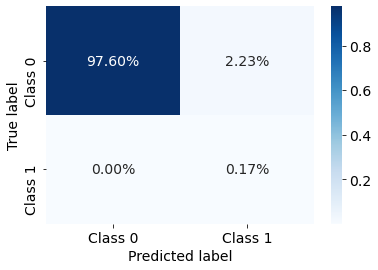

In [34]:
# Instantiate (start up) model
rf = RandomForestClassifier(max_features = 'log2', n_estimators = 100, random_state=42)
# Fit model on the training data
rf.fit(X_under_train, y_under_train)

# Score the model on it's accuracy using cross validation
rf_score = cross_val_score(rf, X_test, y_test, cv=3)
print(f'Random Forest score: {rf_score.mean(): .5f} +/- {2*rf_score.std(): .6f}')

# Predicting the classes from the test set
y_pred_rf = rf.predict(X_test.values)

# Creating a confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, cmap='Blues',
            fmt='.2%', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_test, y_pred_rf))

As you can see random forest out preforms logistic regression with better recall accuracy. However, when looking closer we few False Negatives but around 3% false positives. This would still impact customer satisfaction negativly similar to logistic regression. It would be a wise idea look at precision vs recall to tune the model.

# **Plotting ROC Curve and Precision-Recall Curve.**

* Because our problems relies on the "positive" class being more interesting than the negative class, but as we have calculated the recall precision, I am not going to plot the precision recall curves yet.

* AUC and ROC curve are also interesting to check if the model is also predicting as a whole correctly and not making many errors

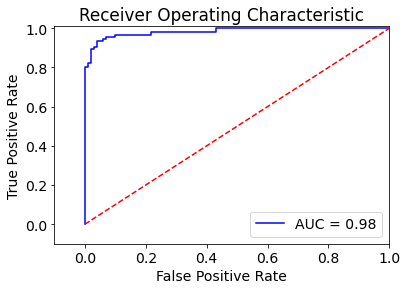

In [35]:
# ROC CURVE
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear' )
y_pred_undersample_score = lr.fit(X_under_train,y_under_train.values.ravel()).decision_function(X_under_test.values)

fpr, tpr, thresholds = roc_curve(y_under_test.values.ravel(),y_pred_undersample_score)
roc_auc = auc(fpr,tpr)

# Plot ROC
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.0])
plt.ylim([-0.1,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

the AOC is near 1.0 which means the model is an excellant classifier. However, this set is not representative of the real population but the undersample set. We should also test this set on other undersample configurations to check that our parameters are optimal

# Logistic Regression Classifier - Skewed Data

Now we need to test the algorithim on the skewed data. My suspicion is the skewness will introduce issues difficult to capture and produce a lower recall score.

Logistic Regression Score:  0.999 +/-  0.0007
Recall metric in the testing dataset:  0.673469387755102


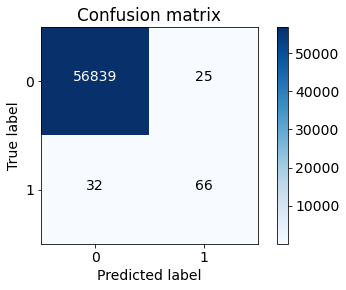

In [36]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X_train,y_train.values.ravel())
y_pred_undersample = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test,y_pred_undersample)
np.set_printoptions(precision=2)

# Score the model on it's accuracy using cross validation
lr_score = cross_val_score(lr, X_test, y_test, cv=7)
print(f'Logistic Regression Score: {lr_score.mean(): .3f} +/- {2*lr_score.std(): .4f}')
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

It is clear that by undersampling our algorithms are much better at detecting fraud.

We can also tweak model by changing threshold. Lets test is with undersampled data.

Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  1.0
Recall metric in the testing dataset:  0.968421052631579
Recall metric in the testing dataset:  0.9263157894736842
Recall metric in the testing dataset:  0.8947368421052632
Recall metric in the testing dataset:  0.8842105263157894
Recall metric in the testing dataset:  0.8631578947368421
Recall metric in the testing dataset:  0.8105263157894737
Recall metric in the testing dataset:  0.7684210526315789


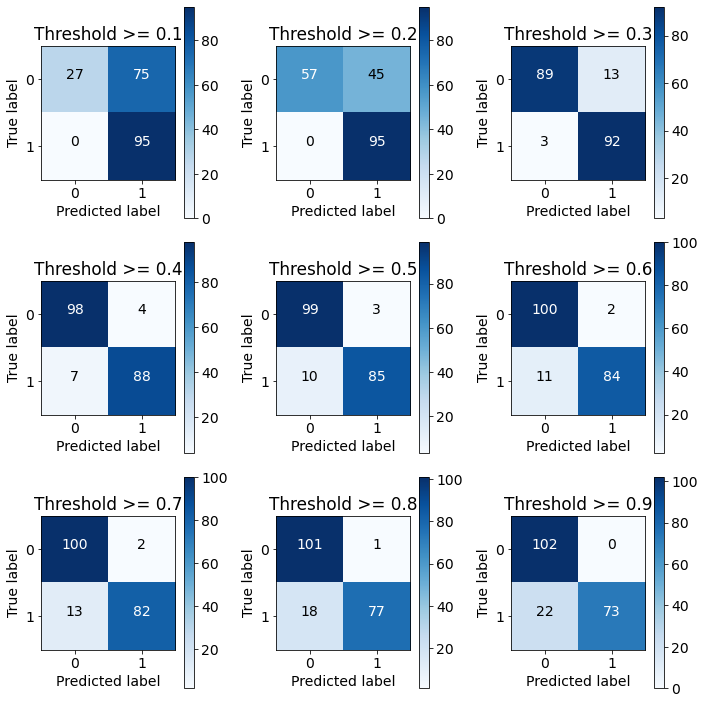

In [37]:
lr = LogisticRegression(C = 0.1, penalty = 'l2', solver = 'liblinear')
lr.fit(X_under_train,y_under_train.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_under_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

plt.figure(figsize=(10,10))

j = 1
for i in thresholds:
    y_test_predictions_high_recall = y_pred_undersample_proba[:,1] > i
    
    plt.subplot(3,3,j)
    j += 1
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_under_test,y_test_predictions_high_recall)
    np.set_printoptions(precision=2)

    print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

    # Plot non-normalized confusion matrix
    class_names = [0,1]
    plot_confusion_matrix(cnf_matrix
                          , classes=class_names
                          , title='Threshold >= %s'%i)

Setting the threshold to .3-.6 performs the best. As recal increases precision decreases. Therefore, even though recall is our most important metric to reduce false negatives we also do not want to misclassify other classes as well. Testing the thresholds precision vs recall could therefore be a useful tool to decide the optimal metric for our model.

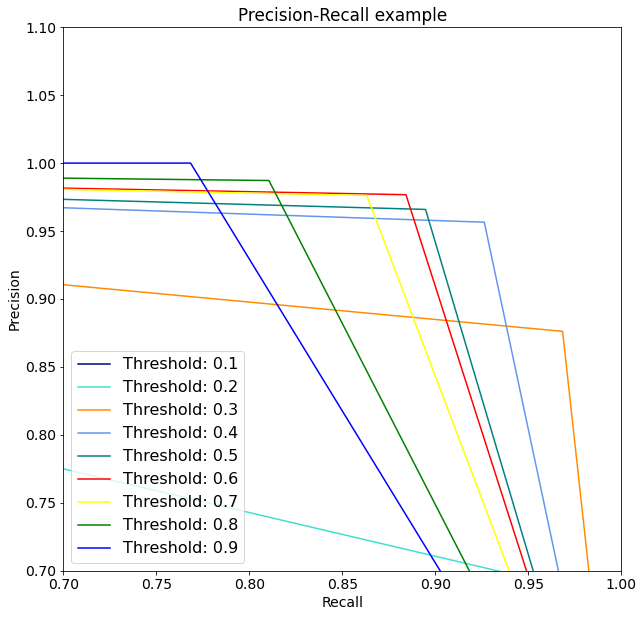

In [38]:
from itertools import cycle

lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X_under_train, y_under_train.values.ravel())
y_pred_undersample_proba = lr.predict_proba(X_under_test.values)

thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black'])

plt.figure(figsize=(10,10))

j = 1
for i,color in zip(thresholds,colors):
    y_test_predictions_prob = y_pred_undersample_proba[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_under_test,y_test_predictions_prob)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,
                 label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.7, 1.1])
    plt.xlim([0.7, 1.0])
    plt.title('Precision-Recall example')
    plt.legend(loc="lower left", prop={'size': 16})

Here the threshold of .3-.6 performs the best overall. Only thing that could imporve the model beyond what I have done already is feature engineering. This requires evaluating which features are the most important.

# Feature Engineering

In [39]:
corr = data.corrwith(data['Class']).sort_values(ascending = False)
print(corr.head(10))

Class    1.000000
V11      0.154876
V4       0.133447
V2       0.091289
V21      0.040413
V19      0.034783
V20      0.020090
V8       0.019875
V27      0.017580
V28      0.009536
dtype: float64


In [40]:
corr = data.corrwith(data['Class']).sort_values(ascending = True)
print(corr.head(12))

V17   -0.326481
V14   -0.302544
V12   -0.260593
V10   -0.216883
V16   -0.196539
V3    -0.192961
V7    -0.187257
V18   -0.111485
V1    -0.101347
V9    -0.097733
V5    -0.094974
V6    -0.043643
dtype: float64


seems positive coorelations drop off significantly after the first 6 and negative correlations after the first 12

In [41]:
# Creating a DataFrame with feature importances
impt = pd.DataFrame(zip(X_test.columns, rf.feature_importances_), columns=['Column name', 'Feature Importance'])
impt.sort_values(by='Feature Importance', ascending=False)
print(impt.sort_values(by='Feature Importance', ascending=False).head(17))

   Column name  Feature Importance
14         V14            0.160356
12         V12            0.106784
4           V4            0.098410
17         V17            0.076882
3           V3            0.068787
11         V11            0.067514
2           V2            0.052810
16         V16            0.051059
10         V10            0.049471
7           V7            0.040858
9           V9            0.026148
21         V21            0.019070
18         V18            0.017375
19         V19            0.015744
28         V28            0.014231
27         V27            0.013578
20         V20            0.012715


when looking at a features performance overall the first 7 seem to compose most of the data. I don't feel like removing 23 features because I will limit the data I am analayzing too severly. I would prefer to keep around 90% data.

In [42]:
print(impt.sort_values(by='Feature Importance', ascending=False).head(17).sum())

Column name           V14V12V4V17V3V11V2V16V10V7V9V21V18V19V28V27V20
Feature Importance                                          0.891792
dtype: object


For this attempt I will try focusing on the 17 most important features which will still compose 90% of the original dataset.

In [43]:
#create new dataset containing only the 17 features of interest.

new_data = data[['Class','V14', 'V4', 'V10', 'V12', 'V17',
                'V11', 'V3', 'V16', 'V2', 'V9', 'V21',
                'V19', 'V7', 'Amount', 'V6', 'V18', 'V26']]

In [44]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Class   284807 non-null  int64  
 1   V14     284807 non-null  float64
 2   V4      284807 non-null  float64
 3   V10     284807 non-null  float64
 4   V12     284807 non-null  float64
 5   V17     284807 non-null  float64
 6   V11     284807 non-null  float64
 7   V3      284807 non-null  float64
 8   V16     284807 non-null  float64
 9   V2      284807 non-null  float64
 10  V9      284807 non-null  float64
 11  V21     284807 non-null  float64
 12  V19     284807 non-null  float64
 13  V7      284807 non-null  float64
 14  Amount  284807 non-null  float64
 15  V6      284807 non-null  float64
 16  V18     284807 non-null  float64
 17  V26     284807 non-null  float64
dtypes: float64(17), int64(1)
memory usage: 39.1 MB


In [45]:
#create new TT split so that enitre dataset and undersampled one are equal in shape with the 17 features of interest
# Remove 'id' and 'target' columns
labels = data.drop(['Class'], axis=1)

X = labels
y = data['Class']


X_train, X_test, y_train, y_test = train_test_split(data.drop(columns = ['Class']),data['Class'],test_size = 0.2, random_state = 42)

Checking for codoing errors from the split.

In [46]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56962 entries, 43428 to 59490
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    56962 non-null  float64
 1   V1      56962 non-null  float64
 2   V2      56962 non-null  float64
 3   V3      56962 non-null  float64
 4   V4      56962 non-null  float64
 5   V5      56962 non-null  float64
 6   V6      56962 non-null  float64
 7   V7      56962 non-null  float64
 8   V8      56962 non-null  float64
 9   V9      56962 non-null  float64
 10  V10     56962 non-null  float64
 11  V11     56962 non-null  float64
 12  V12     56962 non-null  float64
 13  V13     56962 non-null  float64
 14  V14     56962 non-null  float64
 15  V15     56962 non-null  float64
 16  V16     56962 non-null  float64
 17  V17     56962 non-null  float64
 18  V18     56962 non-null  float64
 19  V19     56962 non-null  float64
 20  V20     56962 non-null  float64
 21  V21     56962 non-null  float64

1    492
0    492
Name: Class, dtype: int64


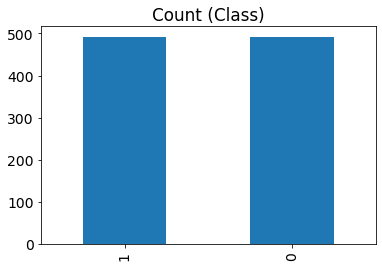

In [47]:
#create new dataset only containg 17 features of interest

# number of fraud cases
fraud = len(new_data[new_data['Class'] == 1])

#get indices of non fraud samples
non_fraud_indices = new_data[new_data.Class == 0].index

#Random sample non fraud indices
random_indices = np.random.choice(non_fraud_indices,fraud, replace=False)

#find fraud samples
fraud_indices = new_data[new_data.Class == 1].index

#concat fraud indices with sample non-fraud ones
under_sample_indices = np.concatenate([fraud_indices,random_indices])

#balance the DF
under_sample = new_data.loc[under_sample_indices]


# histograms of new data
print(under_sample.Class.value_counts())
under_sample.Class.value_counts().plot(kind='bar', title='Count (Class)');

In [48]:
#setup train and test sets with the 17 features of interest for the undersampling training set and test to check

X2_under = under_sample.loc[:,under_sample.columns != 'Class']
y2_under = under_sample.loc[:,under_sample.columns == 'Class']
X2_under_train, X2_under_test, y2_under_train, y2_under_test = train_test_split(X_under,y_under,test_size = 0.2, random_state = 2)

Checking to make sure there are no coding errors in the split.

In [49]:
X2_under.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 984 entries, 541 to 216800
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V14     984 non-null    float64
 1   V4      984 non-null    float64
 2   V10     984 non-null    float64
 3   V12     984 non-null    float64
 4   V17     984 non-null    float64
 5   V11     984 non-null    float64
 6   V3      984 non-null    float64
 7   V16     984 non-null    float64
 8   V2      984 non-null    float64
 9   V9      984 non-null    float64
 10  V21     984 non-null    float64
 11  V19     984 non-null    float64
 12  V7      984 non-null    float64
 13  Amount  984 non-null    float64
 14  V6      984 non-null    float64
 15  V18     984 non-null    float64
 16  V26     984 non-null    float64
dtypes: float64(17)
memory usage: 138.4 KB


In [50]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Logistic Regression check

Tune parameters for best fit

In [51]:
# define dataset
X = X2_under_train
y = y2_under_train
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
penalty = ['l2', 'l1']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937715 using {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.927578 (0.025884) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.933918 (0.024628) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.933057 (0.023030) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.504890 (0.012253) with: {'C': 100, 'penalty': 'l2', 'solver': 'sag'}
0.498534 (0.007648) with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'newton-cg'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'lbfgs'}
0.929271 (0.026612) with: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
0.000000 (0.000000) with: {'C': 100, 'penalty': 'l1', 'solver': 'sag'}
0.498107 (0.007182) with: {'C': 100, 'penalty': 'l1', 'solver': 'saga'}
0.929693 (0.025182) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.937715 (0.021904) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.933057 (0.023030) with: {'C': 10, 'penalty'

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/opt/con

Logistic Regression Score:  0.939 +/-  0.0497
Recall metric in the testing dataset:  0.8947368421052632


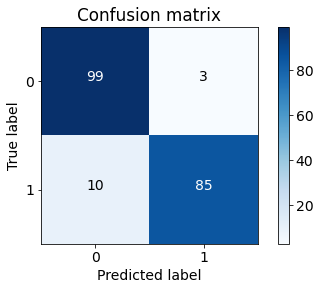

In [52]:
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X2_under_train,y2_under_train.values.ravel())
y_pred_undersample = lr.predict(X2_under_test.values)

# Score the model on it's accuracy using cross validation
lr_score = cross_val_score(lr, X2_under_test, y2_under_test, cv=7)
print(f'Logistic Regression Score: {lr_score.mean(): .3f} +/- {2*lr_score.std(): .4f}')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y2_under_test,y_pred_undersample)
np.set_printoptions(precision=2)

print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

94.9 cvs and 92.6 recall with lr. Not bad slight improvement from earlier

# Decision Tree Check

Tune parameters for best fit.

In [53]:
# How to optimize hyper-parameters of a DecisionTree model using Grid Search in Python ?
def Snippet_146_Ex_2():
    print('**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**\n')

    # importing libraries
    from sklearn import decomposition, datasets
    from sklearn import tree
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler
    
    # Loading wine dataset
    data = pd.read_csv("/kaggle/input/creditcardfraud/creditcard.csv")
    X = X2_under_train
    y = y2_under_train

    # Creating an standardscaler object
    std_slc = StandardScaler()

    # Creating a pca object
    pca = decomposition.PCA()

    # Creating a DecisionTreeClassifier
    dec_tree = tree.DecisionTreeClassifier()

    # Creating a pipeline of three steps. First, standardizing the data.
    # Second, tranforming the data with PCA.
    # Third, training a Decision Tree Classifier on the data.
    pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('pca', pca),
                           ('dec_tree', dec_tree)])

    # Creating Parameter Space
    # Creating a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
    n_components = list(range(1,X.shape[1]+1,1))

    # Creating lists of parameter for Decision Tree Classifier
    criterion = ['gini', 'entropy']
    max_depth = [2,4,6,8,10,12]

    # Creating a dictionary of all the parameter options 
    # Note that we can access the parameters of steps of a pipeline by using '__’
    parameters = dict(pca__n_components=n_components,
                      dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

    # Conducting Parameter Optmization With Pipeline
    # Creating a grid search object
    clf_GS = GridSearchCV(pipe, parameters)

    # Fitting the grid search
    clf_GS.fit(X, y)

    # Viewing The Best Parameters
    print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
    print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
    print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
    print(); print(clf_GS.best_estimator_.get_params()['dec_tree'])

   
Snippet_146_Ex_2()

**Optimizing hyper-parameters of a Decision Tree model using Grid Search in Python**

Best Criterion: gini
Best max_depth: 6
Best Number Of Components: 14

DecisionTreeClassifier(max_depth=6)


In [54]:
# Instantiate (start up) model
dt = DecisionTreeClassifier( criterion = 'entropy', max_depth = 6, random_state=42)
# Fit model on the training data
dt.fit(X2_under_train, y2_under_train)

# Score the model on it's accuracy using cross validation
dt_score = cross_val_score(dt, X2_under_test, y2_under_test, cv=29)
print(f'Decision Tree Score: {dt_score.mean(): .3f} +/- {2*dt_score.std(): .4f}')

Decision Tree Score:  0.897 +/-  0.2511


Recall metric in the testing dataset:  0.9157894736842105


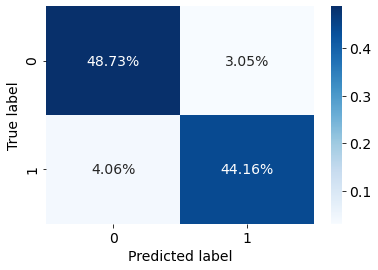

In [55]:
import seaborn as sns
# Predicting the classes from the test set
y_pred_dt = dt.predict(X2_under_test)

# Creating a confusion matrix
cm_dt = confusion_matrix(y2_under_test, y_pred_dt)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_dt/np.sum(cm_dt), annot=True, cmap='Blues', 
            fmt='.2%')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y2_under_test, y_pred_dt))

# Random Forest Check

Tune parameters for best fit.

In [56]:
# define dataset
X = X2_under_train
y = y2_under_train
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2', 'auto']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Best: 0.931359 using {'max_features': 'auto', 'n_estimators': 1000}
0.925019 (0.024429) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.930093 (0.024763) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.929233 (0.026093) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.922482 (0.026582) with: {'max_features': 'log2', 'n_estimators': 10}
0.930082 (0.025678) with: {'max_features': 'log2', 'n_estimators': 100}
0.926269 (0.024964) with: {'max_features': 'log2', 'n_estimators': 1000}
0.921633 (0.024205) with: {'max_features': 'auto', 'n_estimators': 10}
0.928394 (0.025555) with: {'max_features': 'auto', 'n_estimators': 100}
0.931359 (0.024327) with: {'max_features': 'auto', 'n_estimators': 1000}


In [57]:
# Instantiate (start up) model
rf = RandomForestClassifier(max_features = 'auto', n_estimators = 100, random_state=42)
# Fit model on the training data
rf.fit(X2_under_train, y2_under_train)

# Score the model on it's accuracy using cross validation
rf_score = cross_val_score(rf, X2_under_test, y2_under_test, cv=3)
print(f'Random Forest Score: {rf_score.mean(): .5f} +/- {2*rf_score.std(): .6f}')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Plea

Random Forest Score:  0.93901 +/-  0.025700


Recall metric in the testing dataset:  0.9263157894736842


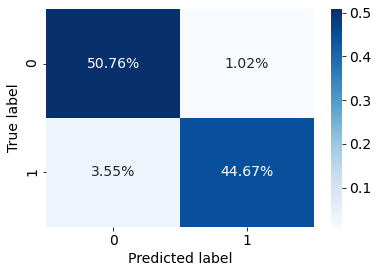

In [58]:
# Predicting the classes from the test set
y_under_pred_rf = rf.predict(X2_under_test)

# Creating a confusion matrix
cm_rf = confusion_matrix(y2_under_test, y_under_pred_rf)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, cmap='Blues',
            fmt='.2%')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y2_under_test, y_under_pred_rf))

# Support Vector Machine Check

Tune parameters for best fit.

In [59]:
# define dataset
X = X2_under_train
y = y2_under_train
# define model and parameters
model = SVC()
kernel = ['poly', 'rbf', 'sigmoid']
C = [50, 10, 1.0, 0.1, 0.01]
gamma = ['scale']
# define grid search
grid = dict(kernel=kernel,C=C,gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.557811 using {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543433 (0.052047) with: {'C': 50, 'gamma': 'scale', 'kernel': 'poly'}
0.545153 (0.056640) with: {'C': 50, 'gamma': 'scale', 'kernel': 'rbf'}
0.485811 (0.059202) with: {'C': 50, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543427 (0.051977) with: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
0.539608 (0.057324) with: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
0.485384 (0.060687) with: {'C': 10, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.543433 (0.052654) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'poly'}
0.524370 (0.061591) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'rbf'}
0.486644 (0.058130) with: {'C': 1.0, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.544704 (0.053181) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}
0.521411 (0.060547) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
0.557811 (0.039727) with: {'C': 0.1, 'gamma': 'scale', 'kernel': 'sigmoid'}
0.546825 (0.048819) with: {'C': 0.01, 'gamma': 'sca

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [60]:
# Instantiate (start up) model
svc = SVC(C = .1, gamma ='scale', kernel = 'sigmoid', random_state=42)
# Fit model on the training data
svc.fit(X2_under_train, y2_under_train)

# Score the model on it's accuracy using cross validation
svc_score = cross_val_score(svc, X2_test, y2_test, cv=3)
print(f'Support Vector Machine Classifier Score: {svc_score.mean(): .3f} +/- {2*svc_score.std(): .4f}')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


NameError: name 'X2_test' is not defined

Recall metric in the testing dataset:  0.1368421052631579


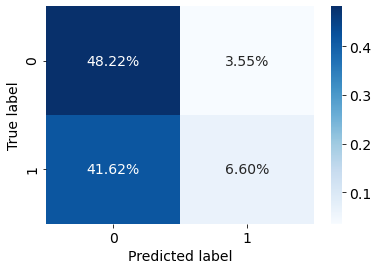

In [61]:
# Predicting the classes from the test set
y_pred_svc = svc.predict(X2_under_test)

# Creating a confusion matrix
cm_svc = confusion_matrix(y2_under_test, y_pred_svc)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_svc/np.sum(cm_svc), annot=True, cmap='Blues',
            fmt='.2%')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y2_under_test, y_pred_svc))

 **Results**
    
    New Models
    1. Logistic Regression             cvs = 93.6 recall = 93.4
    2. Decision Trees                  cvs = 89.7 recall = 93.6
    3. Random Forest                   cvs = 95.4 recall = 92.6
    4. Support Vector Classifier       cvs = 99.8 recall = 13.7

    Previous Models    
    1. Logistic Regression             cvs = 93.4 recall = 93.7
    2. Decision Trees                  cvs = 89.7 recall = 93.7
    3. Random Forest                   cvs = 94.4 recall = 91.6
    4. Support Vector Classifier       cvs = 99.8 recall = 13.7

When reducing the amount of features there was not a significant change. Logistic regression and random forest are still the two best and they will be used on the entire dataset.

# ****Apply Feature Engineered Undersample Training Models to Entire Dataset****

# Logistic Regression

In [62]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
# Use this C_parameter to build the final model with the whole training dataset and predict the classes in the test
# dataset
lr = LogisticRegression(C = .1, penalty = 'l2', solver = 'liblinear')
lr.fit(X2_under_train,y2_under_train.values.ravel())
y_pred = lr.predict(X_test.values)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y2_test,y_pred)
np.set_printoptions(precision=2)

# Score the model on it's accuracy using cross validation
lr_score = cross_val_score(lr, X_test, y_test, cv=7)
print(f'Logistic Regression Score: {lr_score.mean(): .3f} +/- {2*lr_score.std(): .4f}')
print("Recall metric in the testing dataset: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

NameError: name 'y2_test' is not defined

# Random Forest

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest score:  0.99947 +/-  0.000172
Recall metric in the testing dataset:  0.9795918367346939


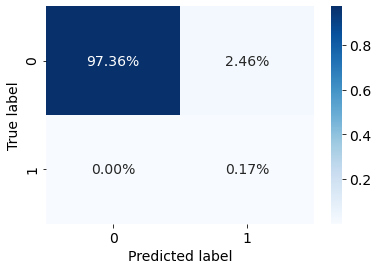

In [63]:
# Instantiate (start up) model
rf = RandomForestClassifier(max_features = 'auto', n_estimators = 100, random_state=42)
# Fit model on the training data
rf.fit(X2_under_train, y2_under_train)

# Score the model on it's accuracy using cross validation
rf_score = cross_val_score(rf, X_test, y_test, cv=3)
print(f'Random Forest score: {rf_score.mean(): .5f} +/- {2*rf_score.std(): .6f}')

# Predicting the classes from the test set
y_pred_rf = rf.predict(X_test.values)

# Creating a confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
# Visualizing the confusion matrix as a heatmap
sns.heatmap(cm_rf/np.sum(cm_rf), annot=True, cmap='Blues',
            fmt='.2%')
plt.ylabel('True label')
plt.xlabel('Predicted label');
print ("Recall metric in the testing dataset: ", recall_score(y_test, y_pred_rf))

Previous Results
         
         CVS       Recall
    LR   99.9       91.8
    RF   99.94      96.94

New Models
         
         CVS       Recall
    LR   99.9       90.8
    RF   99.947     98.0

Overall, there was not much improvement from previous results. I could potentially remove more features to test this but for now since the models still preformed pretty well I will conclude my work.

# **Future Work**

One area I did not address was outliers. I avoided this due to not losing data from the original DF and I didn't have a clear idea of what features I was working with due to privacy of confidential information. Therefore, to understand their impact I would need to do a boxplot on at least the features that were impactful (V14, V10, V17, V12).

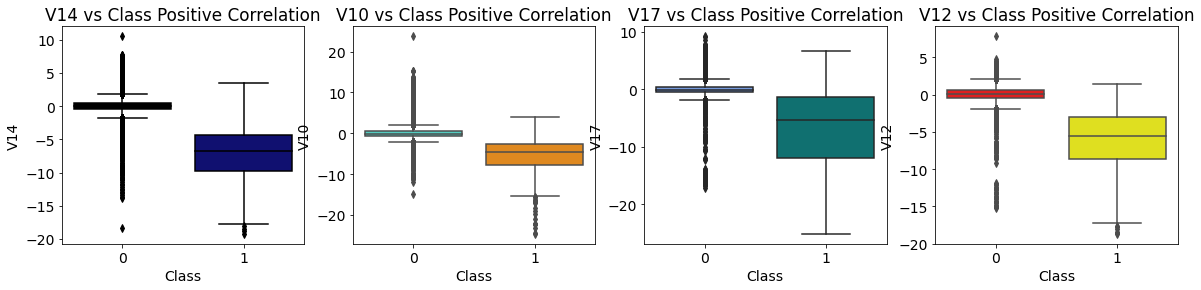

In [64]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V14", data=new_data, palette=colors, ax=axes[0])
axes[0].set_title('V14 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V10", data=new_data, palette=colors, ax=axes[1])
axes[1].set_title('V10 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V17", data=new_data, palette=colors, ax=axes[2])
axes[2].set_title('V17 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V12", data=new_data, palette=colors, ax=axes[3])
axes[3].set_title('V12 vs Class Positive Correlation')

plt.show()

As shown the data has many outliers present that could influence the results. Therefore, taking the log or square root of the data could improve model performance as some values are negative and Boxcox is not viable. Another option done by another kaggle users for this dataset is to manipulate the IQR by changing the threshold.

Another thing I did not explore due to the models performaning fairly well with undersampling is performing oversampling or SMOTE (Synthetic Minority Over-sampling Technique). Both could be applied and yield different results from what I have done.

Other Ideas:

1. Run some statistical hypothesis tests on our features to determine if there is statistical significance in their difference between risk buckets.
2. Use different metrics to evaluate your baseline classification models and determine the best model more objectively.
3. Tune the hyperparameters on your best model to improve model performance.